<a href="https://colab.research.google.com/github/NainaniJatinZ/Hack_Inversion-SIH/blob/main/Notebooks/Forecasting/Final_Model_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [45]:
!pip install -q statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 17.5 MB/s 


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib
import pickle

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/SIH- Hack Inversion/Coding/data/nymex_4ind.csv')
data.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low,SMA,EMA,MACD,DateTime,Custom
0,0,2012-03-12,2.269,82299.0,2.272,2.289,2.235,0.0,0.0,0.0,2012-03-12,100.0
1,1,2012-03-13,2.299,114622.0,2.270,2.338,2.207,0.0,0.0,0.0,2012-03-13,100.0
2,2,2012-03-14,2.284,120435.0,2.329,2.343,2.248,0.0,0.0,0.0,2012-03-14,100.0
3,3,2012-03-15,2.279,117788.0,2.275,2.331,2.234,0.0,0.0,0.0,2012-03-15,100.0
4,4,2012-03-16,2.326,112037.0,2.267,2.349,2.247,0.0,0.0,0.0,2012-03-16,100.0


In [4]:
data = data[['Date', 'Close', 'Volume']]

# Data Preprocess and feature addition

In [6]:
data = data.fillna(data.mean())
data.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Date      0
Close     0
Volume    0
dtype: int64

## Indicators 

### SMA EMA

In [9]:
def sma(data_series, window_size):
  windows = data_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  # return without_nans
  moving_averages_list = [0 if math.isnan(x) else x for x in moving_averages_list]
  return moving_averages_list

def calculate_ema(prices, window_size, smoothing=2):
    ema = [sum(prices[:window_size]) / window_size]
    for price in prices[window_size:]:
        ema.append((price * (smoothing / (1 + window_size))) + ema[-1] * (1 - (smoothing / (1 + window_size))))
    # print(len(ema))
    
    emaList = [0 for i in range(window_size-1)]
    emaList = [y for x in [emaList, ema] for y in x]
    # emaList = emaList + ema
    return emaList

In [10]:
ma = sma(data['Close'], 21*7)
ema = calculate_ema(data['Close'], 21*7)

### MACD

In [13]:
ema1 = calculate_ema(data['Close'], 12*7)
ema2 = calculate_ema(data['Close'], 26*7)

macd = list()
for i in range(len(ema1)):
  macd.append(ema1[i] - ema2[i])

### Custom

In [14]:
u = [sum(x)/2 for x in zip(ma, ema)]
Kr = 0.3
Kp = 0.9
custom = list()
for i in range(len(u)):
  P = data['Close'][i]
  if (P > u[i]*(1 - Kr)) and (P < u[i]*(1 + Kr)):

    x = ((P - u[i])*Kp*100)/(u[i]*Kr)

  elif (P < u[i]*(1 - Kr)):

    x = (P*(1 - Kp)/(u[i]*(1 - Kr)) - 1)*100

  else:
    
    x = (1 - (u[i]*(1 + Kr)*(1 - Kp))/P)*100
  custom.append(x)

In [15]:
data['SMA']= pd.Series(ma)
data['EMA']= pd.Series(ema)
data['MACD']= pd.Series(macd)
data['Custom'] = pd.Series(custom)

## Data Split

In [17]:
data = data[181:]


,Date,Close,Volume,SMA,EMA,MACD,Custom
181,2012-11-20,3.832,80570.000000,2.941027,2.973668,0.467012,88.726702
182,2012-11-21,3.903,123661.000000,2.952034,2.986227,0.470099,90.110506
183,2012-11-22,3.903,121511.051917,2.962456,2.998615,0.472959,90.072518
184,2012-11-23,3.901,49151.000000,2.973667,3.010810,0.475574,90.028429
185,2012-11-26,3.730,77693.000000,2.983122,3.020529,0.475823,72.773162
...,...,...,...,...,...,...,...
2549,2022-03-07,4.833,125430.000000,4.647027,4.358809,0.197045,21.991202
2550,2022-03-08,4.527,152372.000000,4.649701,4.361082,0.195706,1.438861
2551,2022-03-09,4.526,87262.000000,4.652871,4.363310,0.194350,1.191819
2552,2022-03-10,4.631,75295.000000,4.656558,4.366928,0.194314,7.929785


In [18]:
data = data.reset_index()
data = data.drop(columns = ['index'])

In [23]:
train_df = data.iloc[:int(len(data)*0.7)]
test_df = data.iloc[int(len(data)*0.7):]

## Normalize volume

In [28]:
train = train_df
scaler = MinMaxScaler(feature_range=(-4,4))
s_s = scaler.fit_transform(train['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
train['Volume']=s_s
test = test_df
s_s = scaler.transform(test['Volume'].values.reshape(-1,1))
s_s=np.reshape(s_s,len(s_s))
test['Volume']=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [35]:
train = train.drop(columns = ['Date'])
test = test.drop(columns = ['Date'])

# Models

## LSTM

In [31]:
lstm = tf.keras.models.load_model("/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/model_e4d4.h5")

In [80]:
n_future = 700

In [39]:
init_test = np.expand_dims(test.iloc[-50:, :], axis=0)
init_test = np.asarray(init_test).astype(np.float32)

for i in range(int(n_future/30)):
  pred_init = lstm.predict(init_test[:,-50:,:])
  init_test = np.concatenate((init_test, pred_init), axis = 1)

In [43]:
pred_val = init_test[:, :, 0]

In [82]:
test_index = []
for i in range(int(len(data)*0.7), int(len(data)*0.7)+ n_future+50):
  test_index.append(i)

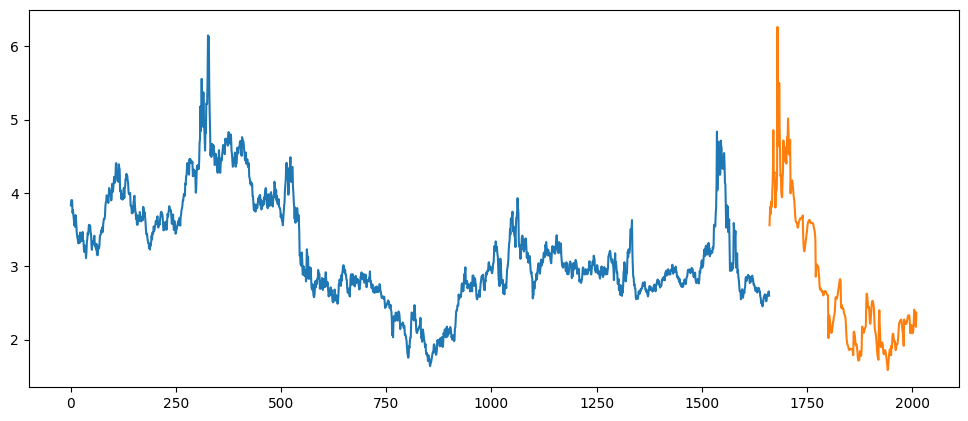

In [51]:
# fc = pd.Series(y_god[0], index=test_index)
fc1 = pd.Series(pred_val[0], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'])
plt.plot(fc1)
# plt.plot(fc)
plt.show()

## ARIMA + ES

In [48]:
arima = joblib.load('/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/arima_direct_fore.pkl')
es = joblib.load('/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/expo_hope.pkl')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [62]:
train

,Close,Volume,SMA,EMA,MACD,Custom
0,3.832,-2.519402,2.941027,2.973668,0.467012,88.726702
1,3.903,-1.727499,2.952034,2.986227,0.470099,90.110506
2,3.903,-1.767010,2.962456,2.998615,0.472959,90.072518
3,3.901,-3.096803,2.973667,3.010810,0.475574,90.028429
4,3.730,-2.572274,2.983122,3.020529,0.475823,72.773162
...,...,...,...,...,...,...
1656,2.595,-1.912946,3.175952,2.930244,-0.155249,-45.013110
1657,2.619,-1.748670,3.171551,2.926038,-0.155903,-42.291581
1658,2.621,-2.022182,3.167041,2.921916,-0.156469,-41.729149
1659,2.659,-2.387470,3.163211,2.918363,-0.156497,-37.666586


(750,)


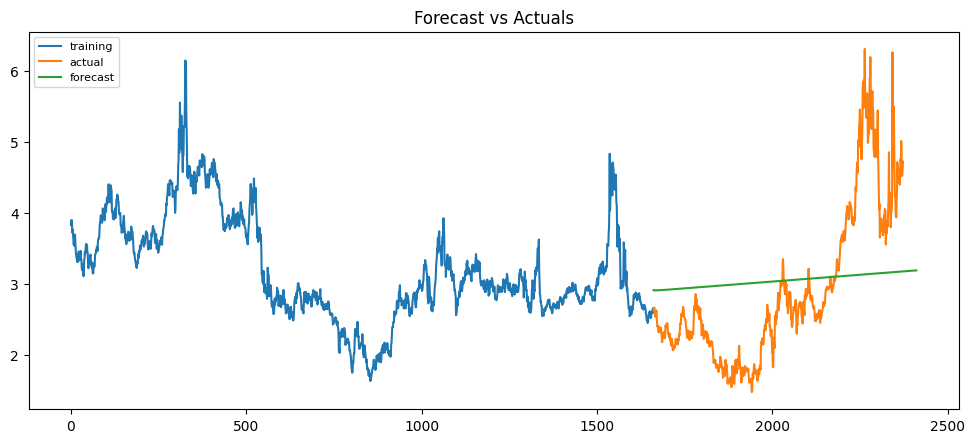

In [83]:
fore, se, conf = arima.forecast(n_future+50, alpha=0.05)
print(fore.shape)

fc_series = pd.Series(fore, index=test_index)
lower_series = pd.Series(conf[:, 0], index=test_index)
upper_series = pd.Series(conf[:, 1], index=test_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='training')
plt.plot(test['Close'], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [84]:
predictions_mul = es.forecast(steps=n_future+50)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [85]:
len(predictions_mul.values.tolist())

750

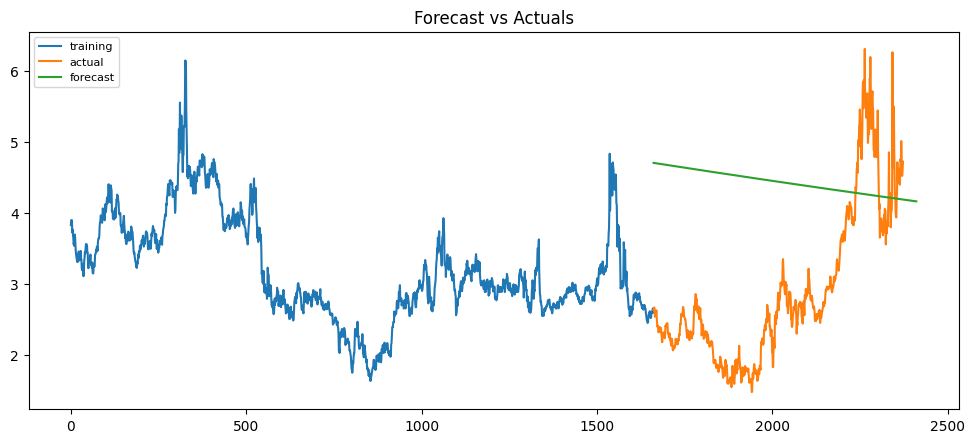

In [86]:
fc_series1 = pd.Series(predictions_mul.values.tolist(), index=test_index)
lower_series = pd.Series(conf[:, 0], index=test_index)
upper_series = pd.Series(conf[:, 1], index=test_index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='training')
plt.plot(test['Close'], label='actual')
plt.plot(fc_series1, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Weight Decision on Hybrid

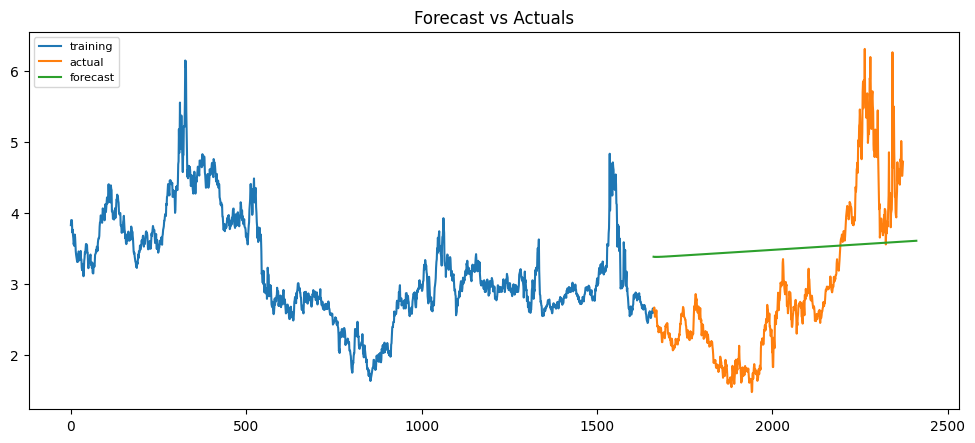

In [88]:
w1 = 1    #@param {type:"slider", min:-1, max:1, step:0.1}
w2 = 0.1    #@param {type:"slider", min:-1, max:1, step:0.1}

fore_this_cast = fc_series*w1  + fc_series1*w2
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='training')
plt.plot(test['Close'], label='actual')
plt.plot(fore_this_cast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
fore_this_cast.values.tolist()

## SVR

In [104]:
with open('/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/svr_final.pkl', 'rb') as pickle_file:
    svm = pickle.load(pickle_file)

# svm = pickle.load('/content/drive/MyDrive/SIH- Hack Inversion/Coding/Models/svr_final.pkl')

In [101]:
init = np.expand_dims(test['Close'][-30:], axis=0)
init

array([[4.639, 4.874, 4.751, 5.501, 4.888, 4.572, 4.232, 4.248, 4.009,
        3.959, 3.941, 4.195, 4.306, 4.717, 4.486, 4.431, 4.498, 4.623,
        4.568, 4.47 , 4.402, 4.573, 4.762, 4.722, 5.016, 4.833, 4.527,
        4.526, 4.631, 4.725]])

In [105]:
init = np.expand_dims(test['Close'][-30:], axis=0)

for i in range(n_future):
  pred=np.expand_dims(svm.predict(init[:, -30:]), axis=0)
  init = np.concatenate((init, pred), axis=1)


In [110]:
test_index_svr = []
for i in range(int(len(data)*0.7), int(len(data)*0.7)+ n_future+30):
  test_index_svr.append(i)

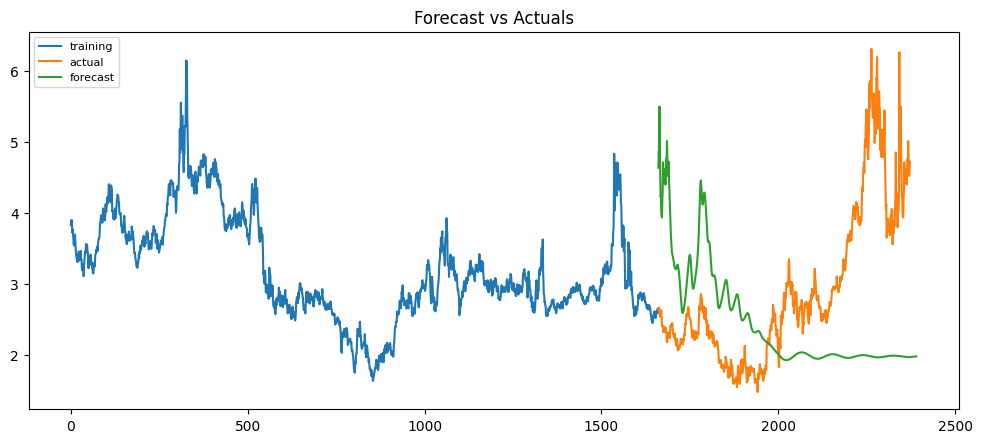

In [111]:
forget_this_cast = pd.Series(init[0], index=test_index_svr)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='training')
plt.plot(test['Close'], label='actual')
plt.plot(forget_this_cast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()